In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# stdlib
import os
import shutil
import sqlite3

# 3rd party
import ipyparallel as ipp
import ipyvolume as ipv
import ipywidgets as ipw
import numpy as np
from scipy.optimize import minimize
import sympy as sp
import matplotlib.pyplot as plt

# local
import convergence as conv
import kelp_analyze
import kelp_compute
import mms
import discrete_plot
import run_utils as ru
from fortran_wrappers.light_utils_wrap import light_utils_wrap as lu

/home/oliver/academic/research/kelp/code/python/kelp_compute.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/oliver/local/miniconda3/envs/k

In [3]:
sp.init_printing()
%matplotlib inline

---

## User-function definitions

In [4]:
def uniform_vsf(delta):
    return 1/(4*sp.pi)

In [5]:
def linear_vsf(delta):
    """Defined on [-1, 1]."""
    return (delta+1)/(4*sp.pi)

In [6]:
# TODO: No upwelling light from bottom
# Also, spatially homogeneous BC
def prod_L(x, y, z, theta, phi, alpha, gamma):
    return (
        (
            (
                (2+sp.sin(2*sp.pi*x/alpha))
                *(2+sp.sin(2*sp.pi*y/alpha))
                *(sp.sin(sp.pi*z/gamma))
            ) + sp.exp(-z/gamma)
        )
        * (2+sp.sin(phi))
    )

In [7]:
def exp_L(x, y, z, theta, phi, b, alpha, gamma):
    return sp.exp(-z) - sp.exp(gamma)

In [8]:
def down_L(x, y, z, theta, phi, b, alpha, gamma):
    return sp.Piecewise((sp.exp(-z), phi<sp.pi/2), (0, True))

In [9]:
def zero_L(x, y, z, theta, phi, b, alpha, gamma):
    return 0 * sp.Symbol('x')

In [10]:
def uniform_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha

In [11]:
def tanh_L(x, y, z, theta, phi, b, alpha, gamma):
    return alpha * (2+sp.sin(z/10)) * sp.tanh((gamma-z)/10) * z * (2+sp.sin(4*sp.pi*x/alpha) + sp.sin(4*sp.pi*y/alpha)) / 5

In [244]:
def tanh_b_L(x, y, z, theta, phi, b, alpha, gamma):
    """
    alpha = rope_spacing
    gamma = zmax
    """
    return (
        alpha * (z/10-gamma/10+sp.tanh((1+b)*(gamma-z)/5) / sp.tanh((1+b)*gamma)/5)
        * (1+z*(sp.sin(2*sp.pi*x/alpha)+sp.sin(2*sp.pi*y/alpha)) / 5)
        *(1+sp.sin(theta+phi))
    )

In [245]:
def prod_a(x, y, z, alpha, gamma):
    return 1 + (3+sp.sin(2*sp.pi*x/alpha)+sp.sin(2*sp.pi*y/alpha))*(1+sp.tanh(z-gamma)) / 20

In [246]:
def uniform_a(x, y, z, alpha, gamma):
    return 0.2

In [247]:
def inv_a(x, y, z, alpha, gamma):
    return 1/tanh_L(x, y, z, 0, 0, 0, alpha, gamma)

### Decide here which functions to use.

In [248]:
sol_func = tanh_b_L
abs_func = prod_a
vsf_func = linear_vsf

---

## Calculate source & BC

In [249]:
b = sp.var('b')
params = sp.var('alpha, gamma')

source_expr = mms.calculate_source(sol_func, b, abs_func, vsf_func, params)
bc_expr = mms.calculate_bc(sol_func, b, params)

# Evaluate other expressions as well for consistency
sol_expr = sol_func(*mms.space, *mms.angle, b, *params)
abs_expr = abs_func(*mms.space, *params)
vsf_expr = vsf_func(mms.delta)

## Specify parameter values

In [292]:
# Domain size
rope_spacing = 1
zmax = 1
b = 0.5

param_vals = {
    'alpha': rope_spacing,
    'gamma': zmax,
    'b': b
}

## Generate symbolic and numerical functions

In [293]:
# Generate symbolic functions
source_sym = mms.symify(source_expr, *mms.space, *mms.angle, **param_vals)
abs_sym = mms.symify(abs_expr, *mms.space, **param_vals)
bc_sym = mms.symify(bc_expr, *mms.angle, **param_vals)
vsf_sym = mms.symify(vsf_expr, mms.delta, **param_vals)
sol_sym = mms.symify(sol_expr, *mms.space, *mms.angle, **param_vals)

# Generate numerical functions
abs_func_N = mms.sym_to_num(abs_sym, *mms.space)
source_func_N = mms.sym_to_num(source_sym, *mms.space, *mms.angle)
bc_func_N = mms.sym_to_num(bc_sym, *mms.angle)
vsf_func_N = mms.sym_to_num(vsf_sym, mms.delta)
sol_func_N = mms.sym_to_num(sol_sym, *mms.space, *mms.angle)

## Examine solution dervatives

In [294]:
conv.max_derivs(sol_expr, rope_spacing, zmax, do_space=True, do_angle=True, **param_vals)

{'x': 0.02028987504016356,
 'y': 0.02028987504016356,
 'z': 0.10299457535779552,
 'theta': 0.03435182048051506,
 'phi': 0.03435182048051506}

In [295]:
conv.max_derivs(abs_expr, rope_spacing, zmax, do_space=True, do_angle=False, **param_vals)

{'x': 0.28385649251441836, 'y': 0.28385649251441836, 'z': 0.24937604019289197}

In [296]:
conv.max_derivs(source_expr, rope_spacing, zmax, do_space=True, do_angle=True, **param_vals)

{'x': 0.13104640955844069,
 'y': 0.097751591688486,
 'z': 0.21262470560340427,
 'theta': 0.10144943222414687,
 'phi': 0.12926277062719727}

## Problem Summary

Solution


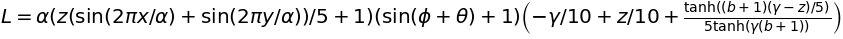


Absorption Coefficient



VSF


Boundary Condition


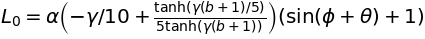


Source


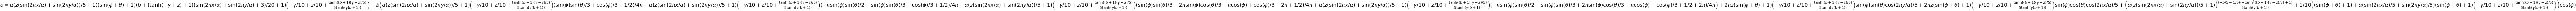

In [297]:
print("Solution")
mms.display_eq('L', sol_expr)
print()

print("Absorption Coefficient")
mms.display_eq('a', abs_expr)
print()

print("VSF")
mms.display_eq('beta', vsf_expr)

print("Boundary Condition")
mms.display_eq('L_0', bc_expr)
print()

print("Source")
mms.display_eq('sigma', source_expr)
print()

## Check solution constraints

- Everything is periodic in x, y
- Absorption coefficient is positive
- Boundary condition depends only on angle
- No upwelling light from below
- Properly normalized VSF

In [298]:
# Check bottom BC
print('bottom:', sp.expand(sol_expr.subs('z',sp.Symbol('gamma'))) == 0)

# Check periodicity
smax = sp.Symbol('alpha')/2
smin = -smax
print('x:', sp.expand(sol_expr.subs('x',smax) - sol_expr.subs('x',smin)) == 0)
print('y:', sp.expand(sol_expr.subs('y',smax) - sol_expr.subs('y',smin)) == 0)

# Check VSF normalization (Should be 1 over whole sphere, or 1/(2pi) on [-1, 1].)
print(
    "VSF:",
    1 == sp.expand(
        mms.sphere_integral(
            vsf_expr.subs(
                'Delta', 
                mms.dot(
                    mms.vec_om, 
                    mms.vec_omp)
            ), 
            angle=mms.angle
        )
    )
)

bottom: True
x: True
y: True
VSF: True


## Check source term

If source term appears nonzero, try substituting parameters,
then plugging in analytical solution.

The result should be 0.

In [299]:
diff = mms.check_sol(sol_sym, b, abs_sym, vsf_sym, source_sym)
diff

In [300]:
num_diff = sp.lambdify(
    (*mms.space, *mms.angle),
    diff,
    modules=("numpy",)
)

In [301]:
# Check numerical max on grid in case of numerical error in above expression
np.max(num_diff(*mms.gen_grid(10, 10, 10, 10, 1, 1)))

## Code Verification Study

In [260]:
#remote_config = kelp_param.ParamSpanRemoteConfig()
ipc = ipp.Client()
lv = ipc.load_balanced_view()
dv = ipc.direct_view()
print(ipc.ids)

[0]


/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@oliver-arch')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


In [261]:
ipc.queue_status()

{'unassigned': 0, 0: {'queue': 0, 'completed': 0, 'tasks': 0}}

In [321]:
#base_dir = os.path.join(os.environ['SCRATCH'], 'kelp-results')
base_dir = '/home/oliver/academic/research/kelp-results'

study_name = 'verify_test_12_12_12_b05_uniform_smallderiv'
study_dir = os.path.join(base_dir, study_name)

ns_max = 12
nz_max = 12
ntheta_max = 12
nphi_max = 12

ns_list = range(4, ns_max+1, 2)
nz_list = range(4, nz_max+1, 2)
ntheta_list = range(4, ntheta_max+1, 1)
nphi_list = range(4, nphi_max+1, 2)

# ns_list = [10]
# nz_list = [10]
# ntheta_list = [10]
# nphi_list = [10]

# TODO: Don't actually delete results
#shutil.rmtree(os.path.join(base_dir, study_name), ignore_errors=True)

num_scatters = 0
fd_flag = True

combine_thread, gs_fut = kelp_compute.fd_verify_compute(
    study_name, 
    ns_list, nz_list, ntheta_list, nphi_list, 
    rope_spacing, zmax, b, 
    sol_expr, abs_expr, source_expr, bc_expr, vsf_expr,
    num_scatters, fd_flag,
    param_vals, base_dir=base_dir)

/home/oliver/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@oliver-arch')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


Creating new study directory.
Running grid (12,12,12,12)
Running grid ( 4,12,12,12)
Running grid ( 6,12,12,12)
Running grid ( 8,12,12,12)
Running grid (10,12,12,12)
Running grid (12, 4,12,12)
Running grid (12, 6,12,12)
Running grid (12, 8,12,12)
Running grid (12,10,12,12)
Running grid (12,12, 4,12)
Running grid (12,12, 5,12)
Running grid (12,12, 6,12)
Running grid (12,12, 7,12)
Running grid (12,12, 8,12)
Running grid (12,12, 9,12)
Running grid (12,12,10,12)
Running grid (12,12,11,12)
Running grid (12,12,12, 4)
Running grid (12,12,12, 6)
Running grid (12,12,12, 8)
Running grid (12,12,12,10)
Reading existing runs.
Finished reading existing runs.
Calling solve_rte_with_callbacks(12, 12, 12, 12, 1, 1, 0.5, alpha*(z*(sin(2*pi*x/alpha) + sin(2*pi*y/alpha))/5 + 1)*(sin(phi + theta) + 1)*(-gamma/10 + z/10 + tanh((b + 1)*(gamma - z)/5)/(5*tanh(gamma*(b + 1)))), (tanh(-gamma + z) + 1)*(sin(2*pi*x/alpha) + sin(2*pi*y/alpha) + 3)/20 + 1, alpha*(z*(sin(2*pi*x/alpha) + sin(2*pi*y/alpha))/5 + 1)*(sin

## Analyze convergece

In [322]:
#study_name = 'verify_test_48_16_6_b05_uniform_smallderiv'
#study_dir = os.path.join(base_dir, study_name)

In [325]:
db_path = os.path.join(study_dir, '{}.db'.format(study_name))
conn = sqlite3.Connection(db_path)

ns


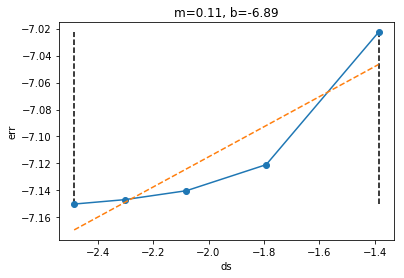

nz


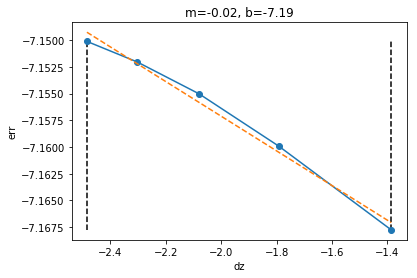

ntheta


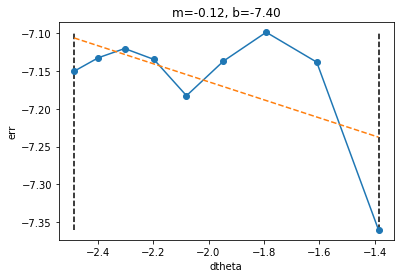

nphi


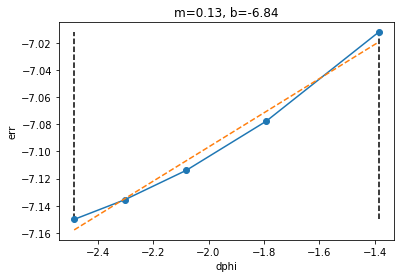

In [326]:
#norm = lambda x: np.linalg.norm(np.ravel(x), ord=2)
#norm = lambda x: np.sqrt(np.sum(x)**2/np.size(x))
norm = lambda x: np.mean(np.abs(x))

dim_names = ('ns', 'nz', 'ntheta', 'nphi')
dim_resolutions = kelp_analyze.get_res_lists(conn, study_name)
max_res_list = list(map(
    max,
    dim_resolutions
))
max_res_dict = {
    name: max_res
    for name, max_res in zip(dim_names, max_res_list)
}
dim_dict = dict(zip(dim_names, dim_resolutions))

# Loop over dimensions
for dim_num, dim_name in enumerate(dim_names):
    # List of resolutions in the current dimension
    current_dim = dim_dict[dim_name]
    
    print(dim_name)
    err_dict = {}
    for n in current_dim:
        all_dims = {**max_res_dict, **{dim_name: n}}
        results_list = kelp_analyze.query_results(
            conn, study_name, 
            **all_dims
        )

        rad = results_list[0]['rad'][:]
        true_rad = results_list[0]['true_rad'][:]

        err = norm(rad - true_rad)
        err_dict[n] = err

    res_arr = rope_spacing / np.array(current_dim)
    err_arr = np.array([err_dict[n] for n in current_dim])

    conv.plot_lin_fit(
        np.log(res_arr), np.log(err_arr), 
        min(np.log(res_arr)), max(np.log(res_arr)), 
        xlabel='d'+dim_name[1:], ylabel='err'
    )

In [274]:
1/0

ZeroDivisionError: division by zero

### Test values

In [ ]:
# Change nz

In [ ]:
ns = 12
nz = 12
ntheta = 10
nphi = 10
grid = mms.gen_grid(ns, nz, ntheta, nphi, rope_spacing, zmax)
x, y, z, theta, phi = grid
x1 = x[:,0,0,0]
y1 = y[0,:,0,0]
z1 = z[0,0,:,0]
results_list = kelp_analyze.query_results(
    conn, study_name, 
    ns=ns, nz=nz, ntheta=ntheta, nphi=nphi
)
large_approx_rad = results_list[0]['rad'][:]
large_approx_irrad = results_list[0]['irrad'][:]
large_true_rad = results_list[0]['true_rad'][:]
large_true_irrad = np.asfortranarray(np.zeros_like(large_approx_irrad))
lu.calculate_irradiance(large_true_rad, large_true_irrad, ntheta, nphi)

ns = 12
nz = 4
ntheta = 10
nphi = 10
grid = mms.gen_grid(ns, nz, ntheta, nphi, rope_spacing, zmax)
x, y, z, theta, phi = grid
x2 = x[:,0,0,0]
y2 = y[0,:,0,0]
z2 = z[0,0,:,0]
results_list = kelp_analyze.query_results(
    conn, study_name, 
    ns=ns, nz=nz, ntheta=ntheta, nphi=nphi
)
small_approx_rad = results_list[0]['rad'][:]
small_approx_irrad = results_list[0]['irrad'][:]
small_true_rad = results_list[0]['true_rad'][:]
small_true_irrad = np.asfortranarray(np.zeros_like(small_approx_irrad))
lu.calculate_irradiance(small_true_rad, small_true_irrad, ntheta, nphi)

large_inds = np.zeros_like(large_approx_rad, dtype=bool)
large_inds[3,1,:,0] = True

small_inds = np.zeros_like(small_approx_rad, dtype=bool)
small_inds[3,1,:,0] = True

plt.plot(z1, large_approx_rad[large_inds], 'o-', label='large_approx')
plt.plot(z1, large_true_rad[large_inds], 'o-', label='large_true')

plt.plot(z2, small_approx_rad[small_inds], 'o-', label='small_approx')
plt.plot(z2, small_true_rad[small_inds], 'o-', label='small_true')
plt.legend()

                                     
#discrete_plot.volshow_zoom_correct_scale(x1, y1, z1, large_irrad, zoom_factor=3),
#discrete_plot.volshow_zoom_correct_scale(x2, y2, z2, small_irrad, zoom_factor=3)

In [ ]:
np.size(large_approx_rad)

In [ ]:
np.size(small_approx_rad)

In [ ]:
norm((small_approx_rad - small_true_rad))

In [ ]:
norm((large_approx_rad - large_true_rad))

In [ ]:
small_approx_rad - small_true_rad

In [ ]:
# Check constraints for numerical solution
# - No upwelling light from below
print("bottom")
print(np.mean(large_approx_rad[:,:,-1,int(nomega/2):]))
# - Periodic in x, y
print("x") 
print(np.mean(large_approx_rad[0,:,:,:]-large_approx_rad[-1,:,:,:]))
print("y") 
print(np.mean(large_approx_rad[:,0,:,:]-large_approx_rad[0,1,:,:]))
# - BC satisfied from above
print("bc above")
print(np.mean(large_approx_rad[:,:,0,:int(nomega/2+1)] - bc_func_N(theta[:,:,0,:int(nomega/2+1)], phi[:,:,0,:int(nomega/2+1)])))

In [ ]:
discrete_plot.volshow_zoom_correct_scale(x1, y1, z1, large_approx_irrad)
discrete_plot.volshow_zoom_correct_scale(x1, y1, z1, large_true_irrad)

In [ ]:
print("hi")

In [ ]:
1/0

# Single-run

### Compute

In [ ]:
# Grid options
ns = 16
nz = 16
na = 10
nomega = na*(na-2) + 2

# Domain size
rope_spacing = 1
zmax = 1

# Solver options
lis_opts = "-i gmres -restart 100 -tol 1e-3"

# Set num_scatters
num_scatters_list = range(5)
max_num_scatters = max(num_scatters_list)

# Norm for error calculations
norm = lambda arr: np.linalg.norm(np.ravel(arr), ord=2)/np.size(arr)

# Numerical function for solution expansion
sol_expansion_N = mms.gen_series_N(sol_expr, max_num_scatters, **param_vals)

asymptotic_sol_dict = {}
sol_expansion_dict = {}
asymptotic_err_dict = {}
sol_expansion_err_dict = {}

for num_scatters in num_scatters_list:
    print("n={}".format(num_scatters))
    # Calculate asymptotic solution
    _, asymptotic_results = kelp_compute.solve_rte_with_callbacks_full(
        ns, nz, na,
        rope_spacing, zmax,
        b, abs_expr, source_expr, source_expansion_N, bc_expr, vsf_expr,
        param_dict, num_scatters=num_scatters, fd_flag=False, lis_opts=lis_opts
    )

    # Extract numerical solutions
    asymptotic_sol = asymptotic_results['rad']
    
    # Store results
    asymptotic_sol_dict[num_scatters] = asymptotic_sol
    
    # Evaluate true solution
    x, y, z, theta, phi = mms.gen_grid(ns, nz, na, rope_spacing, zmax)
    true_sol = sol_func_N(x, y, z, theta, phi)
    
    # Evaluate series expansion
    sol_expansion = np.zeros_like(asymptotic_sol)
    for n in range(num_scatters+1):
        sol_expansion += b**n * sol_expansion_N(x, y, z, theta, phi, n) 
    sol_expansion_dict[num_scatters] = sol_expansion
    
    # Calculate errors
    asymptotic_err = norm(asymptotic_sol-true_sol)
    asymptotic_err_dict[num_scatters] = asymptotic_err
    
    sol_expansion_err = norm(sol_expansion - true_sol)
    sol_expansion_err_dict[num_scatters] = sol_expansion_err

# Evaluate true solution on same grid
true_sol = sol_func_N(x, y, z, theta, phi)

In [ ]:
# Calculate finite difference solution
_, fd_results = kelp_compute.solve_rte_with_callbacks_full(
    ns, nz, na,
    rope_spacing, zmax,
    b, abs_sym, source_sym, source_expansion_N, bc_sym, vsf_sym,
    num_scatters=0, fd_flag=True, lis_opts=lis_opts
)

fd_sol = fd_results['rad']

fd_err = norm(fd_sol-true_sol)

### Plot

In [ ]:
# Pick one angle to evaluate symbolically and plot
l = 0
m = int(np.floor(na/4))

p = mms.p_hat(l, m, na)
th = theta[0,0,0,p]
ph = phi[0,0,0,p]

In [ ]:
plot_inds = np.zeros_like(true_sol, dtype=bool)
plot_inds[0,0,:,p] = True

plt.figure(figsize=(12,8))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

# Plot true solution
ax1.plot(z[plot_inds], true_sol[plot_inds], 'C0o-', label='true')

# Plot FD solution
ax1.plot(
    z[plot_inds],
    fd_sol[plot_inds], 
    'C1o-',
    label='FD'
)

# Plot FD error
ax2.plot(
    z[plot_inds], 
    -true_sol[plot_inds]+fd_sol[plot_inds], 
    'C1o-',
    label='FD'
)

ax3.plot(
    z[plot_inds], 
    np.abs(-true_sol[plot_inds]+fd_sol[plot_inds]), 
    'C1o-',
    label='FD'
)

for num_scatters in num_scatters_list:
    ax1.plot(
        z[plot_inds], 
        sol_expansion_dict[num_scatters][plot_inds], 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    ax1.plot(
        z[plot_inds], 
        asymptotic_sol_dict[num_scatters][plot_inds], 
        'C{}o--'.format(num_scatters+2)
    )
    
    # Plot true expansion error
    ax2.plot(
        z[plot_inds], 
        -true_sol[plot_inds]+sol_expansion_dict[num_scatters][plot_inds], 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    ax3.plot(
        z[plot_inds], 
        np.abs(-true_sol[plot_inds]+sol_expansion_dict[num_scatters][plot_inds]), 
        'C{}o-'.format(num_scatters+2), 
        label='n={}'.format(num_scatters)
    )
    
    # Plot numerical asymptotics error
    ax2.plot(
        z[plot_inds], 
        -true_sol[plot_inds]+asymptotic_sol_dict[num_scatters][plot_inds], 
        'C{}o--'.format(num_scatters+2)
    )
    ax3.plot(
        z[plot_inds], 
        np.abs(-true_sol[plot_inds]+asymptotic_sol_dict[num_scatters][plot_inds]), 
        'C{}o--'.format(num_scatters+2)
    )
    
    
ax1.set_xlabel('z')
ax1.set_ylabel('rad')
ax1.legend()

ax2.set_xlabel('z')
ax2.set_ylabel('stripe diff')
ax2.set_yscale('linear')
ax2.legend()

ax3.set_xlabel('z')
ax3.set_ylabel('stripe err')
ax3.set_yscale('log')
ax3.legend()

# FD Error
ax4.hlines(fd_err, xmin=0, xmax=max_num_scatters, label='FD')

# Asymptotics error
ax4.plot(
    num_scatters_list, 
    [asymptotic_err_dict[n] for n in num_scatters_list],
    'o-',
    label='asym. err.'
)
# Expansion error
ax4.plot(
    num_scatters_list, 
    [sol_expansion_err_dict[n] for n in num_scatters_list],
    'o-',
    label='series err.'
)
ax4.set_xlabel('n')
ax4.set_ylabel('avg. tot. err.')
ax4.set_yscale('linear')
ax4.legend()